# 2D UNet applied to electron microscopic images of brain
data from the ISBI 2012 challenge\
author: Kyle Luther\
updated version 2023

## Setup ##

In [ ]:
# imports
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from skimage import measure
import tifffile


import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
matplotlib.rcParams['axes.grid'] = False

In [ ]:
# utils
def connected_components(boundaries):
    assert(len(boundaries.shape) == 3)
    boundaries = boundaries.astype(np.int64)
    ccs = np.zeros_like(boundaries)
    for z in range(ccs.shape[0]):
        ccs[z] = measure.label(boundaries[z])

    return ccs

def randomize_ids(segs, seed=None, lim=256):
    """Randomly change segment ids. Useful for visualization purposes"""
    np.random.seed(seed)

    segs = np.copy(segs).astype(np.int64)
    size = np.random.randint(lim,2*lim)
    remap = np.random.randint(1,lim+1,size)
    segs[segs != 0] = remap[segs[segs != 0] % size] # dont change 0s

    np.random.seed(None)

    return segs

In [ ]:
# get data
!wget https://github.com/cos485/data/raw/master/isbi2012/train-volume.tif
!wget https://github.com/cos485/data/raw/master/isbi2012/train-labels.tif

imgs = torch.from_numpy(tifffile.imread('train-volume.tif')).float()
imgs -= torch.mean(imgs, (1,2)).reshape((-1,1,1)) # normalize inputs
imgs /= (torch.std(imgs, (1,2)).reshape((-1,1,1)) + 1e-6)

bdys = torch.from_numpy(tifffile.imread('train-labels.tif')).float()
bdys /= 255.

segs = connected_components(bdys.cpu().numpy())

imgs_trn = imgs[:20]
bdys_trn = bdys[:20]
segs_trn = segs[:20]

imgs_val = imgs[20:]
bdys_val = bdys[20:]
segs_val = segs[20:]

print(imgs_trn.shape, imgs_val.shape)

--2024-03-14 02:02:35--  https://github.com/cos485/data/raw/master/isbi2012/train-volume.tif
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cos485/data/master/isbi2012/train-volume.tif [following]
--2024-03-14 02:02:35--  https://raw.githubusercontent.com/cos485/data/master/isbi2012/train-volume.tif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7870730 (7.5M) [application/octet-stream]
Saving to: ‘train-volume.tif’

train-volume.tif    100%[===================>]   7.51M  --.-KB/s    in 0.09s   

2024-03-14 02:02:36 (86.4 MB/s) - ‘train-volume.tif’ saved [7870730/7870730]

--2024-03-14 02:

## Visualize Data ##

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(imgs_trn[0], cmap='gray')
plt.subplot(132)
plt.imshow(bdys_trn[0], cmap='gray')
plt.title('training')
plt.subplot(133)
plt.imshow(randomize_ids(segs_trn[0]), cmap='nipy_spectral')
plt.grid(False)
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(imgs_val[0], cmap='gray')
plt.subplot(132)
plt.imshow(bdys_val[0], cmap='gray')
plt.title('validation')
plt.subplot(133)
plt.imshow(randomize_ids(segs_val[0]), cmap='nipy_spectral')
plt.show()

## Create UNet ##

In [ ]:
# helper operations
def conv3x3(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels,
        kernel_size=3, stride=1, padding=1, bias=True)

def maxpool2x2():
    return nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

class UpConv2x2(nn.Module):
    def __init__(self, channels):
        super(UpConv2x2, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv = nn.Conv2d(channels, channels // 2,
            kernel_size=2, stride=1, padding=0, bias=True)

    def forward(self, x):
        x = self.upsample(x)
        x = F.pad(x, (0,1,0,1))
        x = self.conv(x)
        return x

def concat(xh, xv):
    return torch.cat([xh, xv], dim=1)


# unet blocks
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: number of channels in input (1st) feature map
            out_channels: number of channels in output feature maps
        """
        super(ConvBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels)
        self.relu = nn.ReLU()
        self.conv2 = conv3x3(out_channels, out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x

class DownConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: number of channels in input (1st) feature map
            out_channels: number of channels in output feature maps
        """
        super(DownConvBlock, self).__init__()

        self.downsample = maxpool2x2()
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.downsample(x)
        x = self.conv(x)

        return x

class UpConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: number of channels in input (1st) feature map
            out_channels: number of channels in output feature maps
        """
        super(UpConvBlock, self).__init__()

        self.up = UpConv2x2(in_channels)
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, xh, xv):
        """
        Args:
            xv: torch Variable, activations from same resolution feature maps (gray arrow in diagram)
            xh: torch Variable, activations from lower resolution feature maps (green arrow in diagram)
        """
        x = self.up(xh)
        x = concat(x, xv)
        x = self.conv(x)

        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        fs = [16,32,64,128,256]
        self.conv_in = ConvBlock(1, fs[0])
        self.dconv1 = DownConvBlock(fs[0], fs[1])
        self.dconv2 = DownConvBlock(fs[1], fs[2])
        self.dconv3 = DownConvBlock(fs[2], fs[3])
        self.dconv4 = DownConvBlock(fs[3], fs[4])
        self.uconv1 = UpConvBlock(fs[4], fs[3])
        self.uconv2 = UpConvBlock(fs[3], fs[2])
        self.uconv3 = UpConvBlock(fs[2], fs[1])
        self.uconv4 = UpConvBlock(fs[1], fs[0])
        self.conv_out = conv3x3(fs[0], 1)

    def forward(self, x):
        x1 = self.conv_in(x)
        x2 = self.dconv1(x1)
        x3 = self.dconv2(x2)
        x4 = self.dconv3(x3)
        x5 = self.dconv4(x4)
        x = self.uconv1(x5, x4)
        x = self.uconv2(x, x3)
        x = self.uconv3(x, x2)
        x = self.uconv4(x, x1)
        x = self.conv_out(x)

        return x

## Train UNet ##

In [ ]:
# train utils
def var2np(arr):
    return arr.squeeze().detach().cpu().numpy()

In [ ]:
# plot utils
def plot_learning(plot_handles, ylabel):
    plt.legend(handles=plot_handles, loc="center right")
    plt.xlabel("Iterations")
    plt.ylabel(ylabel)

def plot(step, log_every, train_loss, val_loss, img_trn, img_val, pred_trn, pred_val, true_trn, true_val):
    clear_output(wait=False)
    plt.gcf().clear()

    plt.subplot(241)
    iters = np.arange(0,len(train_loss))*log_every
    train_plot, = plt.plot(iters, train_loss, 'r', label="training")
    val_plot, = plt.plot(iters, val_loss, 'b', label="validation")
    plot_learning([train_plot, val_plot], "Loss")
    plt.title("Cross entropy loss")

    plt.subplot(242)
    plt.imshow(img_trn, cmap='gray')
    plt.title("Input image, train")

    plt.subplot(243)
    plt.imshow(pred_trn, cmap='gray')
    plt.title("Predicted, train")


    plt.subplot(244)
    plt.imshow(true_trn, cmap='gray')
    plt.title("True, train")

    plt.subplot(246)
    plt.imshow(img_val, cmap='gray')
    plt.title("Input image, val")

    plt.subplot(247)
    plt.imshow(pred_val, cmap='gray')
    plt.title("Predicted, val")


    plt.subplot(248)
    plt.imshow(true_val, cmap='gray')
    plt.title("True, val")


    plt.gcf().set_size_inches(18, 7)
    display(plt.gcf())

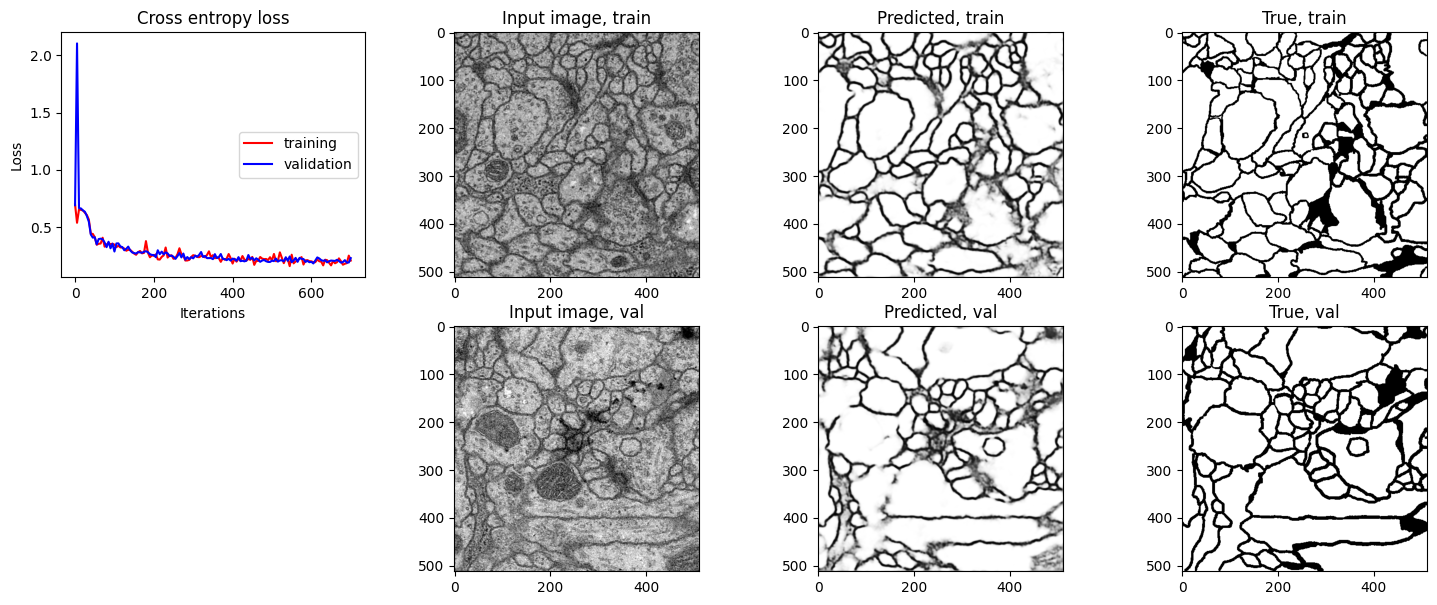

KeyboardInterrupt: 

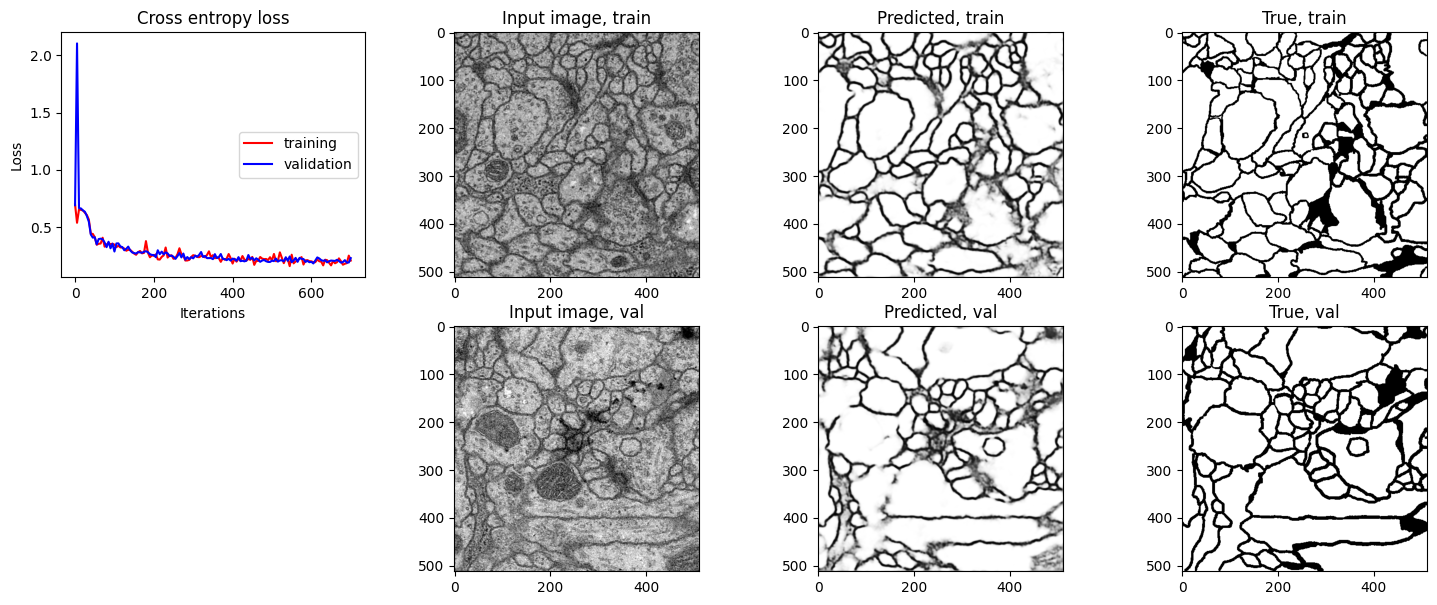

In [ ]:
## Train network ##

# params
max_iter = 2000
log_every = 5
plot_every = 100
lr = 0.001

# create net
net = UNet()
if torch.cuda.is_available():
  net.cuda()
  imgs_trn = imgs_trn.cuda()
  imgs_val = imgs_val.cuda()
  bdys_trn = bdys_trn.cuda()
  bdys_val = bdys_val.cuda()

# create optimizer
optimizer = optim.Adam(net.parameters(), lr=lr)

# train net
losses_trn = []
losses_val = []
for t in range(max_iter):
    # choose sample
    idx = np.random.randint(0,imgs_trn.shape[0])
    img, bdy = imgs_trn[idx], bdys_trn[idx]

    # unsqueeze
    img = img[None, None, :, :]
    bdy = bdy[None, None, :, :]

    # forward, backward, update
    optimizer.zero_grad()
    pred = net(img)
    loss = F.binary_cross_entropy_with_logits(pred, bdy)
    loss.backward()
    optimizer.step()


    # log stuff
    if t % log_every == 0:
        # validation info
        idx = np.random.randint(0,imgs_val.shape[0])
        img_val, bdy_val = imgs_val[idx], bdys_val[idx]

        # unsqueeze
        img_val = img_val[None, None, :, :]
        bdy_val = bdy_val[None, None, :, :]

        # forward
        pred_val = net(img_val)
        loss_val = F.binary_cross_entropy_with_logits(pred_val, bdy_val)

        # store
        losses_trn.append(loss.data.cpu())
        losses_val.append(loss_val.data.cpu())

    # plot stuff
    if t % plot_every == 0:
        plot(t, log_every, losses_trn, losses_val,
             var2np(img), var2np(img_val),
             var2np(F.sigmoid(pred)), var2np(F.sigmoid(pred_val)),
             var2np(bdy), var2np(bdy_val))

## Make Segmentations ##

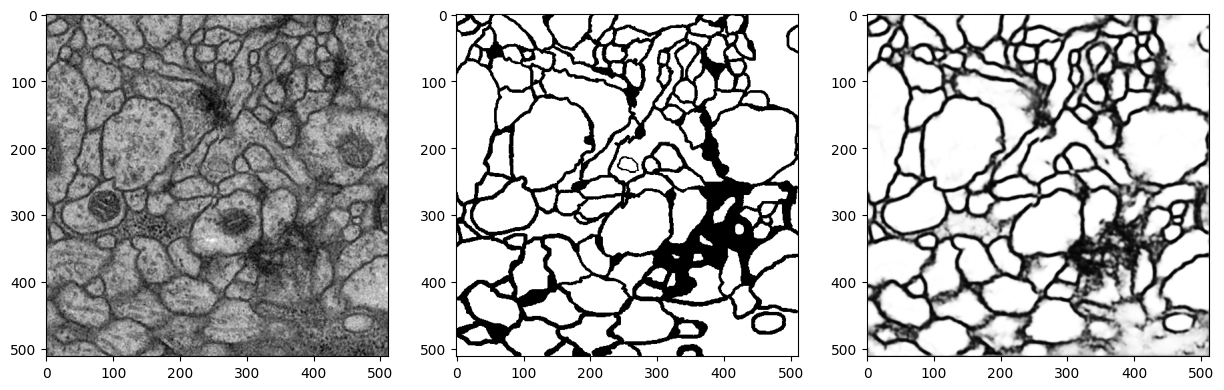

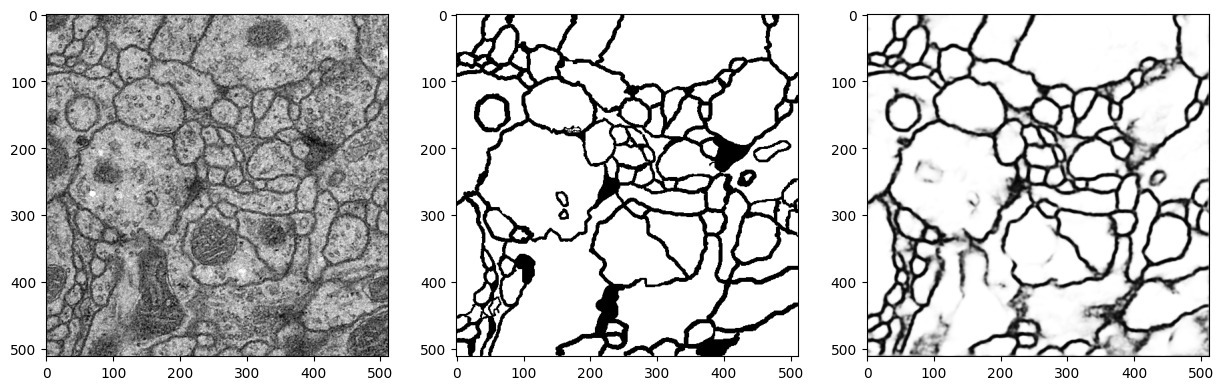

In [ ]:
# inspect outputs
def plot_boundaries(im1, im2, im3):
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.imshow(im1, cmap='gray')
    plt.subplot(132)
    plt.imshow(im2, cmap='gray')
    plt.subplot(133)
    plt.imshow(im3, cmap='gray')
    plt.show()


# training set
img = imgs_trn[5]
true = bdys_trn[5]
pred = torch.sigmoid(net(img[None, None, :, :]))
plot_boundaries(var2np(img), var2np(true), var2np(pred))

# validation set
img = imgs_val[5]
true = bdys_val[5]
pred = torch.sigmoid(net(img[None, None, :, :]))
plot_boundaries(var2np(img), var2np(true), var2np(pred))

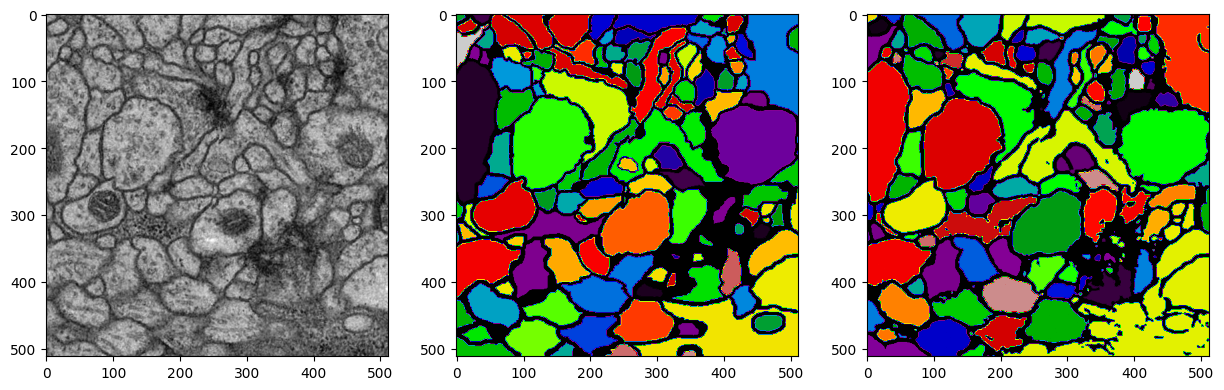

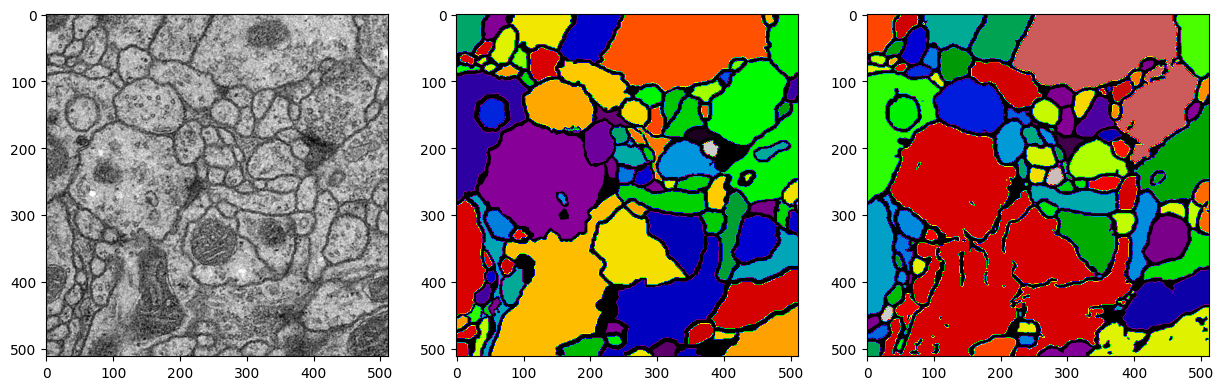

In [ ]:
# analyze results
def plot_segmentations(im1, im2, im3):
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.imshow(im1, cmap='gray')
    plt.subplot(132)
    plt.imshow(im2, cmap='nipy_spectral')
    plt.subplot(133)
    plt.imshow(im3, cmap='nipy_spectral')
    plt.show()

# training
z = 5
img = imgs_trn[z]
bdy_true = bdys_trn[z]
bdy_pred = var2np(torch.sigmoid(net(img[None, None, :, :]))) > 0.5
seg_true = randomize_ids(segs_trn[z])
seg_pred = randomize_ids(connected_components(np.expand_dims(bdy_pred, 0))[0])
plot_segmentations(var2np(img), seg_true, seg_pred)

# validation
z = 5
img = imgs_val[z]
bdy_true = bdys_val[z]
bdy_pred = var2np(torch.sigmoid(net(img[None, None, :, :]))) > 0.5
seg_true = randomize_ids(segs_val[z])
seg_pred = randomize_ids(connected_components(np.expand_dims(bdy_pred, 0))[0])
plot_segmentations(var2np(img), seg_true, seg_pred)